In [35]:
import numpy as np
import os
import sys
from scipy.stats import f

import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib import pyplot as plt
import pandas as pd
import numpy.ma as ma
from netCDF4 import Dataset

sys.path.append(os.path.abspath('../../py'))
from predictability import var_noise, var_signal, potential_predictability, perfect_skill

In [36]:
path_in = '../../data'

season = 'djf'  # 'djf' or 'jja'
models = ['cfsv2', 'seas5']

seas5_arr = np.load(os.path.join(path_in, f'seas5_{season}.npz'))['WS10M']
cfsv2_arr = np.load(os.path.join(path_in, f'cfsv2_{season}.npz'))['WS10M']
lon_arr = np.load(os.path.join(path_in, f'cfsv2_{season}.npz'))['longitude']
lat_arr = np.load(os.path.join(path_in, f'cfsv2_{season}.npz'))['latitude']

In [37]:
list_cfsv2 = [var_signal(cfsv2_arr)]
list_cfsv2.append(var_noise(cfsv2_arr))
list_cfsv2.append(potential_predictability(cfsv2_arr))
list_cfsv2.append(perfect_skill(cfsv2_arr))

list_seas5 = [var_signal(seas5_arr)]
list_seas5.append(var_noise(seas5_arr))
list_seas5.append(potential_predictability(seas5_arr))
list_seas5.append(perfect_skill(seas5_arr))

data_graph = [list_cfsv2, list_seas5]

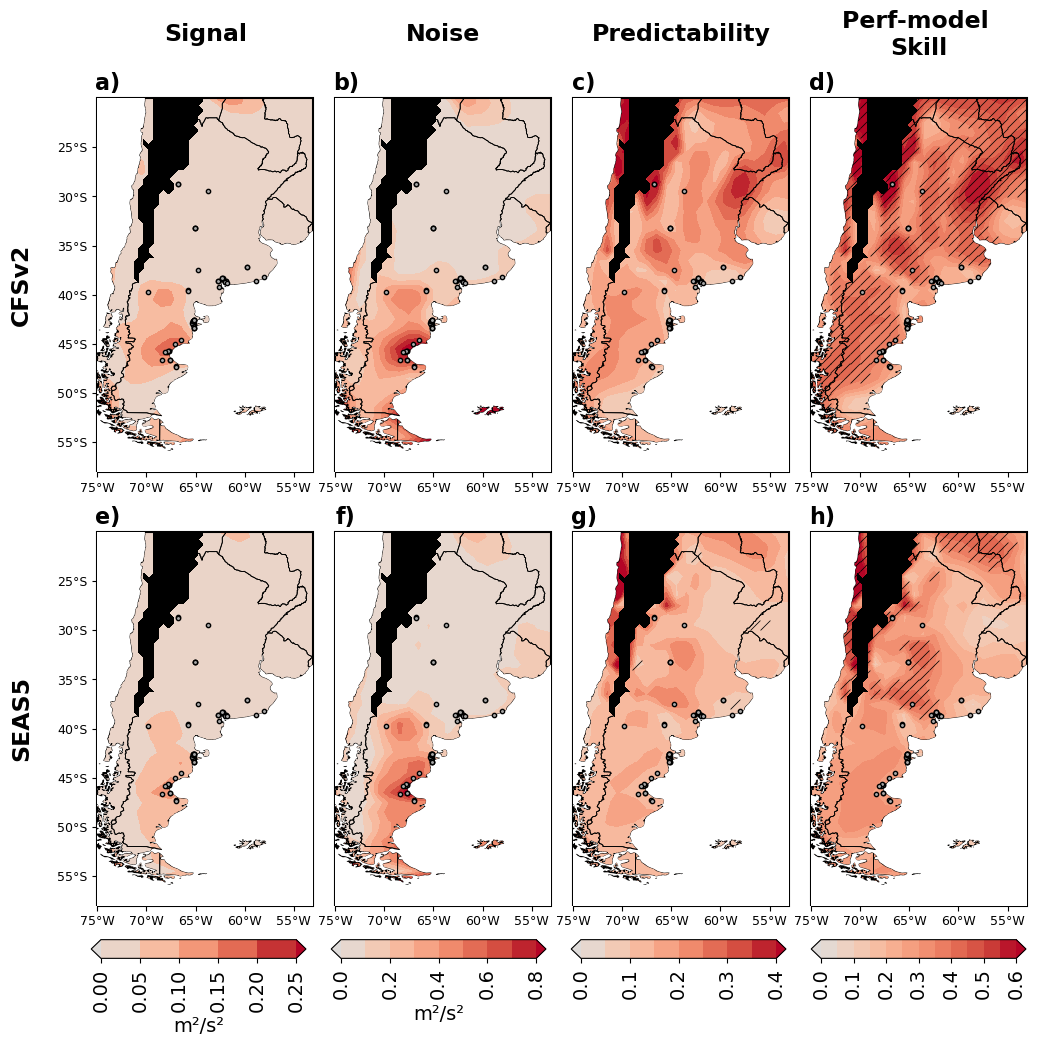

In [44]:
letters = [['a)', 'b)', 'c)', 'd)'],
           ['e)', 'f)', 'g)', 'h)']]
variables = ['Signal', 'Noise', 'Predictability', 'Perf-model \nSkill']
var_levels = [np.arange(0, 0.30, 0.05),  # signal
              np.arange(0, 0.90, 0.1),  # noise
              np.arange(0, 0.45, 0.05),
              np.arange(0, 0.65, 0.05)]
bases = ['CFSv2', 'ECMWFs5']

latnorth, latsouth, lonwest, loneast = -20, -58, -75, -53

lon, lat = np.meshgrid(lon_arr, lat_arr)

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none',
    edgecolor='black'
)
countries = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='10m',
    facecolor='none',
    edgecolor='white'
)

# Custom colormap
coolwarm = plt.get_cmap('coolwarm')
warm_coolwarm = mcolors.ListedColormap(coolwarm(np.linspace(0.51, 1.0, 256)))

# Load wind farm locations
df = pd.read_json(path_in + "/eolicos.json").T
lats_w = df.apply(lambda row: row['Lat'][0], axis=1).tolist()
lons_w = df.apply(lambda row: row['Lat'][1], axis=1).tolist()

# Load elevation data
elev_file = '/home/carla/Desktop/Tesis/Datos/elev.0.5-deg.nc'
elev_data = Dataset(elev_file, mode='r')
lons_ele, lats_ele = np.meshgrid(elev_data.variables['lon'][:], elev_data.variables['lat'][:])
elev = ma.masked_where(elev_data.variables['data'][:] < 1500, elev_data.variables['data'][:])

# Prepare mask for elevation
data = np.full_like(elev, np.nan, dtype=np.float64)
data[elev > 1500] = False

# Constants for statistical tests
M, T = [28, 25], 24

fig, axs = plt.subplots(2, 4, figsize=(12, 11), subplot_kw={'projection': ccrs.PlateCarree()})

for i, base in enumerate(bases):
    for j, variable in enumerate(variables):
        ax = axs[i, j]
        
        if j == 0:
            ax.set_yticks(np.arange(-55, latnorth, 5), crs=ccrs.PlateCarree())
            ax.yaxis.set_major_formatter(LatitudeFormatter())

        ax.set_xticks(np.arange(lonwest, loneast, 5), crs=ccrs.PlateCarree())
        ax.xaxis.set_major_formatter(LongitudeFormatter())

        ax.tick_params(axis='both', labelsize=9)
        ax.set_extent([lonwest, loneast, latsouth, latnorth], crs=ccrs.PlateCarree())

        ax.add_feature(countries, linewidth=0.6, edgecolor='black')
        ax.add_feature(cfeature.OCEAN, facecolor="white", alpha=1, zorder=100, linewidth=0.6)

        ax.contourf(lons_ele, lats_ele, data[0], cmap='gist_gray', levels=np.linspace(0, 5000, 10), extend='both', zorder=100)
        ax.scatter(lons_w, lats_w, c='darkgray', s=9.5, edgecolors='k', zorder=100)

        cf = ax.contourf(lon, lat, data_graph[i][j], cmap=warm_coolwarm, levels=var_levels[j],
                         transform=ccrs.PlateCarree(), extend='both')

        ax.annotate(letters[i][j], xy=(0.05, 1.04), xycoords='axes fraction',
                    fontsize=16, fontweight='bold', ha='center', va='center', zorder=100)

        # Statistical significance tests
        if variable == 'Predictability':
            F_crit = f.ppf(0.95, T-1, (M[i]-1) * T)
            idx = (data_graph[i][0] * (M[i]-1) * T / (data_graph[i][1] * (T-1))) < F_crit
            ax.scatter(lon[idx], lat[idx], marker=(2, 0, 315), color='k', s=100, linewidth=0.55)

        if variable == 'Perf-model \nSkill':
            r_crit = 0.3437747
            idx = data_graph[i][j] > r_crit
            ax.scatter(lon[idx], lat[idx], marker=(2, 0, 315), color='k', s=100, linewidth=0.55)

        # Colorbar adjustments
        if i == 1:
            cbar_ax = fig.add_axes([0.120 + j * 0.20, 0.08, 0.179, 0.017])
            cbar = fig.colorbar(cf, cax=cbar_ax, orientation='horizontal', pad=0.1, aspect=20, fraction=0.1)
            cbar.ax.tick_params(axis='x', labelrotation=90, labelsize=14)

            if j in [0, 1]:
                cbar.set_label('m²/s²', fontsize=14)

            if variable == 'Noise':
                cbar.set_ticks(np.round(np.arange(0, 1.0, 0.2), 2))
                cbar.set_ticklabels(np.round(np.arange(0, 1.0, 0.2), 2))

            if variable == 'Predictability':
                cbar.set_ticks(np.round(np.arange(0, 0.5, 0.1), 2))
                cbar.set_ticklabels(np.round(np.arange(0, 0.5, 0.1), 2))


        if i == 0:
            ax.text(0.5, 1.17, variable, ha='center', va='center', fontweight='bold',
                    fontsize=17, transform=ax.transAxes)

        if j == 0:
            ax.text(-0.35, 0.5, 'SEAS5' if i == 1 else base, ha='center', va='center',
                    fontweight='bold', fontsize=17, rotation='vertical', transform=ax.transAxes)


        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.5)

plt.subplots_adjust(wspace=0.1, hspace=0.05)
